In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots,CSV,DataFrames;
import NLsolve,Roots;
import Optim;
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

In [4]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    return sol.zero[1] + im * sol.zero[2]
end
qon_c(E)=find_singular(E, (E, p) -> E-mDn-mDsc - p^2 / (2 * μf(mDn, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDc-mDsn - p^2 / (2 * μf(mDc, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

In [5]:
xxx,www=gauss(96,0,1);

qi=zeros(ComplexF64,2+length(xxx));
wi=zeros(ComplexF64,length(xxx));
len=length(xxx);
sublen=length(qi);

In [6]:
Γsmc(t,Λ,ω,V0)=t+im*V0*(1-exp(-t/ω))*(1-exp((t-Λ)/ω))
dΓsmc(t,Λ,ω,V0)=1+im*V0/ω*(exp(-t/ω)-exp((t-Λ)/ω))

dΓsmc (generic function with 1 method)

In [7]:
Γsmcx(x,Λ,ω,V0)=Γsmc(Λ*x,Λ,ω,V0) #0~x~1
dΓsmcx(x,Λ,ω,V0)=Λ*dΓsmc(Λ*x,Λ,ω,V0)

dΓsmcx (generic function with 1 method)

# VGT

In [8]:
function getqw(E,Λ;ω=0.1,V0=-0.1,qi=qi,wi=wi)
    qi[1],qi[2]=qon_c(E),qon_0(E)
    for i in eachindex(xxx)
        qi[2+i]=Γsmcx(xxx[i],Λ,ω,V0)
        wi[i]=dΓsmcx(xxx[i],Λ,ω,V0)*www[i]
    end
    nothing
end

getqw (generic function with 1 method)

In [9]:
getqw(mDn+mDsc-360e-6-im*24e-6,0.6)

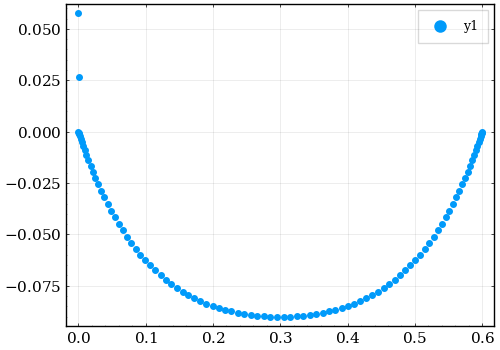

In [10]:
scatter(real.(qi[1:end]),imag.(qi[1:end]))

In [9]:
Vmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Gmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Tmat=zeros(ComplexF64,2*length(qi),2*length(qi));

In [10]:
function VMat!(E;Λ=0.5,a = 0.0,a1=0.0,I=0,plist=qi,isπ=true,des=Vmat)
    getqw(E,Λ)

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I,isπ=isπ)
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,isπ=isπ)
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,isπ=isπ)
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I,isπ=isπ)
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

In [13]:
VMat!(3.875)

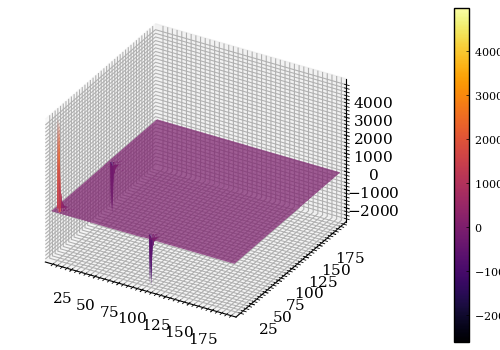

In [14]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

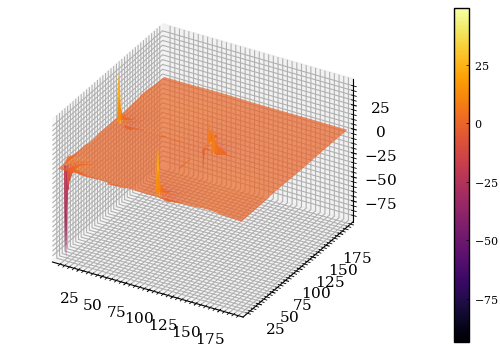

In [15]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

In [11]:
Gc(E,q)=1/(2π^2)/(E-mDn-mDsc-q^2/(2*μf(mDn,mDsc))+im*ΓDscf(E,q)/2)
Gn(E,q)=1/(2π^2)/(E-mDc-mDsn-q^2/(2*μf(mDc,mDsn))+im*ΓDsnf(E,q)/2)

Gn (generic function with 1 method)

In [12]:
function GMat!(E;Λ=0.5,qi=qi,wi=wi,des=Gmat)
    getqw(E,Λ)
    k1,k2=qi[1],qi[2]
    
    i=1
    for j in eachindex(wi)
        des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gc(E,qi[2+j])
    end
    
    i=2
    for j in eachindex(wi)
        des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gn(E,qi[2+j])
    end
    
    return nothing
end

GMat! (generic function with 1 method)

In [13]:
function detVG(E;Λ=0.5,a = 0.0,a1=0.0,I=0)
    VMat!(E;Λ=Λ,a=a,a1=a1,I=I)
    GMat!(E;Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [14]:
function TMat!(E;Λ=0.5,a = 0.0,a1=0.0,I=0,des=Tmat)
    VMat!(E;Λ=Λ,a=a,a1=a1,I=I)
    GMat!(E;Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

In [20]:
@btime TMat!(3.875)

  19.913 ms (2752 allocations: 2.60 MiB)


In [21]:
let 
    function inv_abst(x;E=mDn+mDsc-273e-6,I=0)
        TMat!(E;Λ=x[1],I=I,a1=1.0)
        return 1/abs(Tmat[1,1])
    end
    
    tmpf(x)=inv_abst(x)
    init_val=[0.5]
    lower=[0.3]
    upper=[1.2]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.00020106603511810262
[0.5934394978271114]


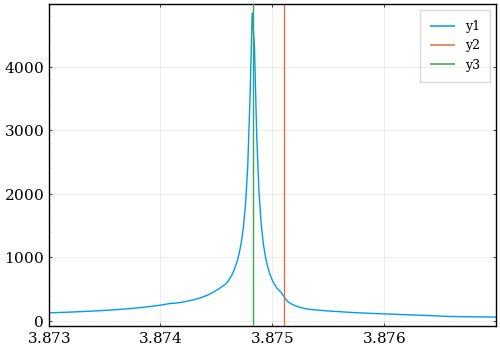

In [22]:
let Ev=collect(3.873:0.00002:3.877)
    function tmpf(E)
        TMat!(E;Λ=0.5934394978271114,a1=1.0)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

# Extract pole position

In [18]:
function find_poles(pars)
    _lam,_a1=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ; Λ = _lam,a1=_a1)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsc - 333e-6, -24e-6])
    (tmp.zero[1]-mDn-mDsc)+im*tmp.zero[2]
end

find_poles (generic function with 1 method)

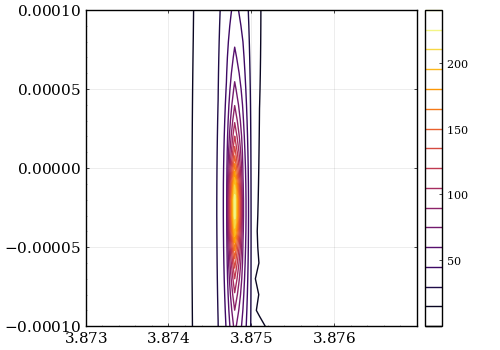

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [25]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;Λ=0.5934394978271114,a1=1.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=false)
end

In [19]:
find_poles([0.5954897610260301,1.0])

-0.00030811265840613444 - 2.41157199288734e-5im

In [20]:
find_poles([0.6086306009844105,0.971352722443013])

-0.0003501994656778251 - 2.349950626947046e-5im